# Regression and DNN Model 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pydot

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import KFold

print(tf.__version__)

2.4.1


# Get Dataset

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Check Null values

In [4]:
#The dataset contains a few unknown values.
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
#Drop those rows to keep this initial tutorial simple.
dataset = dataset.dropna()

## Data Adjusting 

In [6]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


# Splitting Data to training and testing data

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=0)

test_dataset = dataset.drop(train_dataset.index)



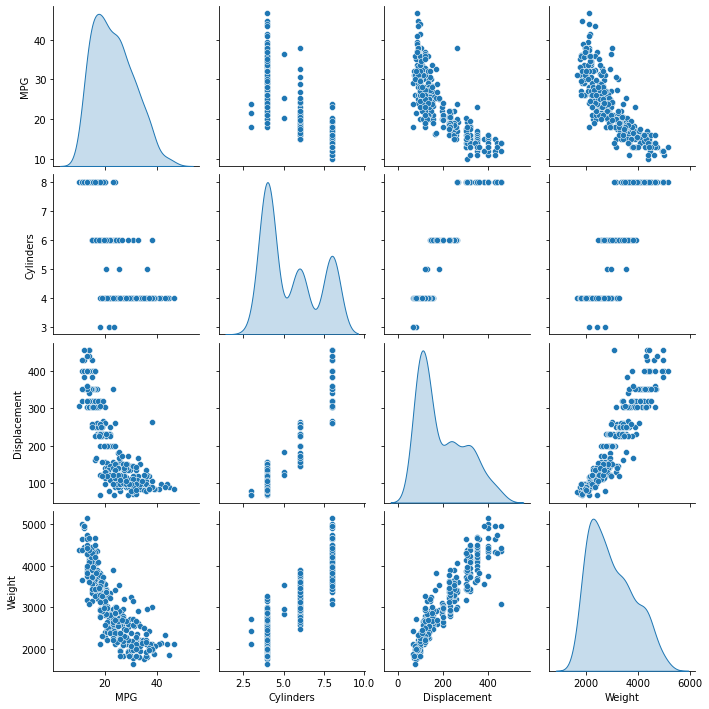

In [8]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [9]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [10]:
#Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.
train_features = train_dataset.copy()
test_features = test_dataset.copy()


train_labels_0 = train_features[['MPG']].copy()
train_labels_1 = train_features[['Cylinders']].copy()

train_features = train_features.drop(['MPG','Cylinders'], axis=1)

test_labels_0 = test_features[['MPG']].copy()
test_labels_1 = test_features[['Cylinders']].copy()

test_features = test_features.drop(['MPG','Cylinders'], axis=1)

acc_per_fold = []
loss_per_fold = []


In [11]:
#In the table of statistics it's easy to see how different the ranges of each feature are.
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


# Data Normalization


In [12]:

normalizer = preprocessing.Normalization()

normalizer.adapt(np.array(train_features))

print(normalizer.mean.numpy())

print(type(normalizer))


[ 195.318  104.869 2990.252   15.559   75.898    0.178    0.197    0.624]
<class 'tensorflow.python.keras.layers.preprocessing.normalization.Normalization'>


In [13]:
first = np.array(train_features[:1])
tx = np.array(train_features)


with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Keras Functional API Model


In [35]:


def build_and_compile_model_0(norm):
    inputs = keras.Input(shape=(8,))

    dense = layers.Dense(64, activation="relu")
    x = dense(inputs)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)

    y = layers.Dense(64, activation="relu")(x)
    z = layers.Dense(64, activation="relu")(x)
    output_mph = layers.Dense(1)(y)
    output_cyl = layers.Dense(1)(z)


    model = keras.Model(inputs=inputs, outputs=[output_mph,output_cyl])
    model.compile(loss=['mean_absolute_error','categorical_crossentropy'], optimizer=tf.keras.optimizers.Adam(0.001),metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.Accuracy(name='accuracy', dtype=None),
            keras.metrics.CategoricalAccuracy()]
    )
    return model

In [36]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(train_features, train_labels_0, train_labels_1):
    dnn_model = build_and_compile_model_0(normalizer)
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = dnn_model.fit(train_features, y= (train_labels_0,train_labels_1), batch_size=64, epochs=60, validation_split=0.1)
    # Generate generalization metrics
    
    scores = dnn_model.evaluate(test_features, (test_labels_0, test_labels_1), verbose=0)
    print(f'Score for fold {fold_no}: {dnn_model.metrics_names[0]} of {scores[0]}; {dnn_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1


se_132_categorical_accuracy: 1.0000 - val_loss: 5.3526 - val_dense_131_loss: 5.3526 - val_dense_132_loss: 6.7800e-07 - val_dense_131_mean_absolute_error: 5.3526 - val_dense_131_accuracy: 0.0000e+00 - val_dense_131_categorical_accuracy: 1.0000 - val_dense_132_mean_absolute_error: 261.0525 - val_dense_132_accuracy: 0.0000e+00 - val_dense_132_categorical_accuracy: 1.0000
Epoch 33/60
5/5 [==============================] - 0s 18ms/step - loss: 5.1719 - dense_131_loss: 5.1719 - dense_132_loss: 6.4647e-07 - dense_131_mean_absolute_error: 5.1719 - dense_131_accuracy: 0.0000e+00 - dense_131_categorical_accuracy: 1.0000 - dense_132_mean_absolute_error: 249.6306 - dense_132_accuracy: 0.0000e+00 - dense_132_categorical_accuracy: 1.0000 - val_loss: 4.6906 - val_dense_131_loss: 4.6906 - val_dense_132_loss: 6.7800e-07 - val_dense_131_mean_absolute_error: 4.6906 - val_dense_131_accuracy: 0.0000e+00 - val_dense_131_categorical_accuracy: 1.0000 - val_dense_132_mean_absolute_error: 257.7402 - val_dense_1

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_125 (Dense)               (None, 64)           576         input_20[0][0]                   
__________________________________________________________________________________________________
dense_126 (Dense)               (None, 64)           4160        dense_125[0][0]                  
__________________________________________________________________________________________________
dense_127 (Dense)               (None, 64)           4160        dense_126[0][0]                  
___________________________________________________________________________________________

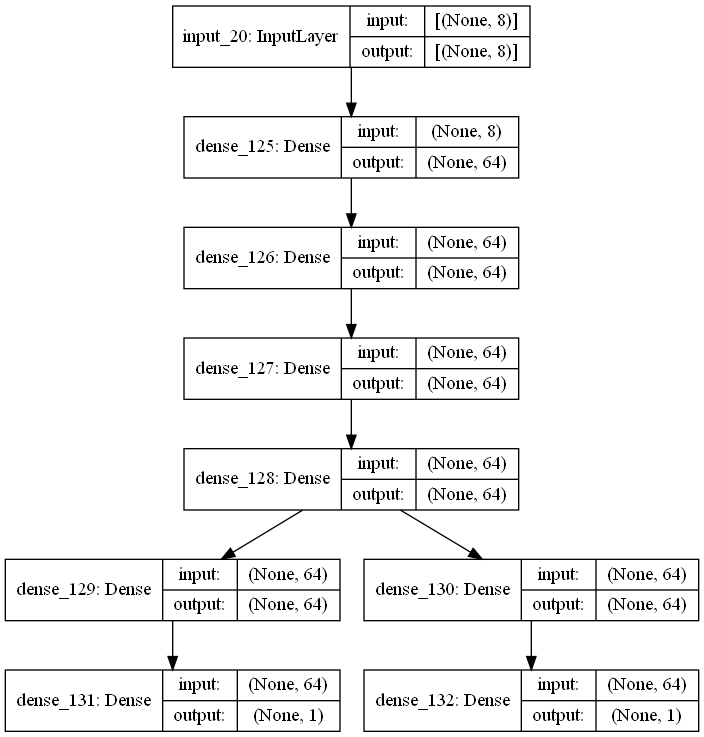

In [37]:
dnn_model.summary()
keras.utils.plot_model(dnn_model, "multi_input_and_output_model.png", show_shapes=True)


# Model Evaluation

In [38]:

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 8.80010986328125 - Accuracy: 880.0108909606934%
------------------------------------------------------------------------
> Fold 2 - Loss: 5.657698154449463 - Accuracy: 565.7697677612305%
------------------------------------------------------------------------
> Fold 3 - Loss: 10.434572219848633 - Accuracy: 1043.45703125%
------------------------------------------------------------------------
> Fold 4 - Loss: 14.1094970703125 - Accuracy: 1410.9495162963867%
------------------------------------------------------------------------
> Fold 5 - Loss: 14.110575675964355 - Accuracy: 1411.0573768615723%
------------------------------------------------------------------------
> Fold 6 - Loss: 13.55350112915039 - Accuracy: 1355.3499221801758%
------------------------------------------------------------------------
> Fold

None


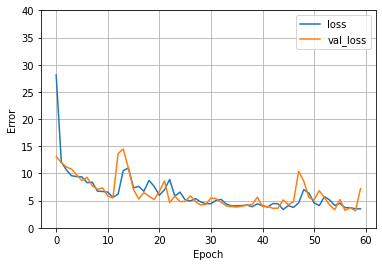

In [39]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 40])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
print(plot_loss(history))

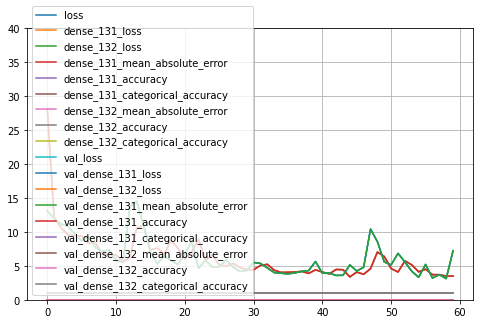

In [40]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 40) 
plt.show()

In [41]:
dnn_model.evaluate(test_features, y=(test_labels_0,test_labels_1), verbose=0)

[6.706363201141357,
 6.706362247467041,
 6.495378102044924e-07,
 6.706362247467041,
 0.0,
 1.0,
 222.1300048828125,
 0.0,
 1.0]

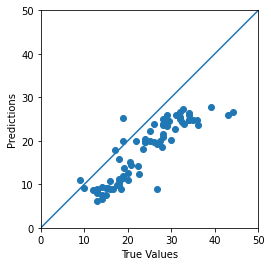

In [42]:
test_predictions = dnn_model.predict(test_features)

a = plt.axes(aspect='equal')
plt.scatter(test_labels_0, test_predictions[0])
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


In [92]:
np.random.__RandomState_ctor

<function numpy.random.__RandomState_ctor()>